# Part 1: Basic Option Valuation
Carry out convergence studies by increasing the number of trials.  <br>
How do your results compare with the results obtained in assignment 1?  <br>
Perform numerical tests for varying values for the strike and the volatility parameter.  <br>
What is the standard error of your estimate and what does this tell you about the accuracy?

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from numba import jit
from scipy import stats

In [75]:
@jit (nopython = True)
def one_step_stock_jit(stock_price, interest_rate, volatility, maturity):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * np.random.normal())

@jit (nopython = True)
def monte_carlo_option_jit(trials, strike_price, stock_price, interest_rate, volatility, maturity):
    # trials are #iterations of monte carlo
    monte_results = []
    for i in range(trials):
        current_monte = one_step_stock_jit(stock_price, interest_rate, volatility, maturity)
        if current_monte - K > 0:
            monte_results.append(current_monte)
        else:
            monte_results.append(0)
        
    return monte_results
    

In [76]:
''' The Monte Carlo method.'''
T = 1
K = 99
r = 0.06
S0 = 100
sigma = 0.2

trials = 10000000
time0 = time.time()

monte_results = monte_carlo_option_jit(trials, K, S0, r, sigma, T)
# print(time.time() - time0)

# Mean and std
monte_mean = np.mean(monte_results)
monte_std = np.std(monte_results)


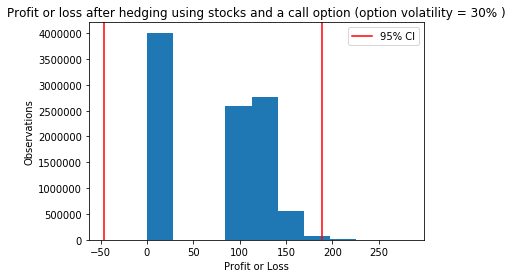

In [77]:
#Payoff kan nooit negatief zijn 
CI95 = stats.norm.interval(0.95, loc = monte_mean, scale = monte_std) 
plt.axvline(CI95[0], color = 'r', label = '95% CI')
plt.axvline(CI95[1], color = 'r')

plt.legend()
plt.hist(monte_results)
plt.ylabel('Observations')
plt.xlabel('Profit or Loss')
plt.title('Profit or loss after hedging using stocks and a call option (option volatility = 30%)')
plt.show()

In [78]:
''' Convergence studies. '''



' Convergence studies. '

In [ ]:
'''  Varying the strike and the volatility. '''

strike_list = [x for x in range(1,201)] #np.linspace(1,200)
# print(strike_list)

profit_list = []
for K in strike_list:
    profit = monte_carlo_option_jit(trials, K, S0, r, sigma, T)
    profit_list.append(profit)
     
plt.plot(strike_list, profit)
plt.title('Varying strike')
plt.xlabel('Strike price')
plt.ylabel('Profit or Loss')
plt.legend()
plt.show()

# Part 2: Estimation of Sensitivities in MC

# Part 3: Variance Reduction